<a href="https://colab.research.google.com/github/shuaicongbaobao/Colab-140/blob/main/Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import pickle
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.models import resnet18



from tqdm import tqdm
import pickle
from PIL import Image
import math
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive', force_remount=True)




Mounted at /content/drive


In [3]:
np.random.seed(0)
torch.manual_seed(0)
model = resnet18(pretrained=True)
model.fc = nn.Linear(512, 5)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
# Load attribute dictionary from file
with open("/content/drive/MyDrive/biased_cars_1/att_dict_simplified.p", "rb") as file:
    attribute_dictionary = pickle.load(file)

# Initialize lists to hold training and testing datasets
training_data = []
testing_data = []

# Retrieve the names of folders containing train and test data
data_folders = os.listdir("/content/drive/MyDrive/biased_cars_1/data")
# Filter out any system files like .DS_Store
data_folders = [folder for folder in data_folders if folder != ".DS_Store"]

image_count = 0
# Iterate through each folder to process train and test images
for folder in tqdm(data_folders):
    for data_split in ["train", "test"]:
        images_directory = f"/content/drive/MyDrive/biased_cars_1/data/{folder}/{data_split}/images"
        for image_file in os.listdir(images_directory):
            # Process files that include 'frame' in their name
            if "frame" in image_file:
                image_count += 1
                file_path = os.path.join(images_directory, image_file)
                image_obj = Image.open(file_path)
                try:
                    # Retrieve the label for the current image
                    label = attribute_dictionary[image_file][2]
                    if data_split == "train":
                        training_data.append((image_obj, label))
                    else:
                        testing_data.append((image_obj, label))
                except KeyError:
                    # Skip files without labels
                    continue

# Define a custom dataset class for the car dataset
class CustomCarDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img, lbl = self.data[index]
        # Convert images to tensors
        img_tensor = transforms.ToTensor()(img)
        return img_tensor, lbl

# Convert lists to custom dataset instances
training_dataset = CustomCarDataset(training_data)
testing_dataset = CustomCarDataset(testing_data)

# Display the total number of images in each dataset
print(f"Total images in training dataset: {len(training_dataset)}")
print(f"Total images in testing dataset: {len(testing_dataset)}")

100%|██████████| 10/10 [00:06<00:00,  1.60it/s]

Total images in training dataset: 498
Total images in testing dataset: 188


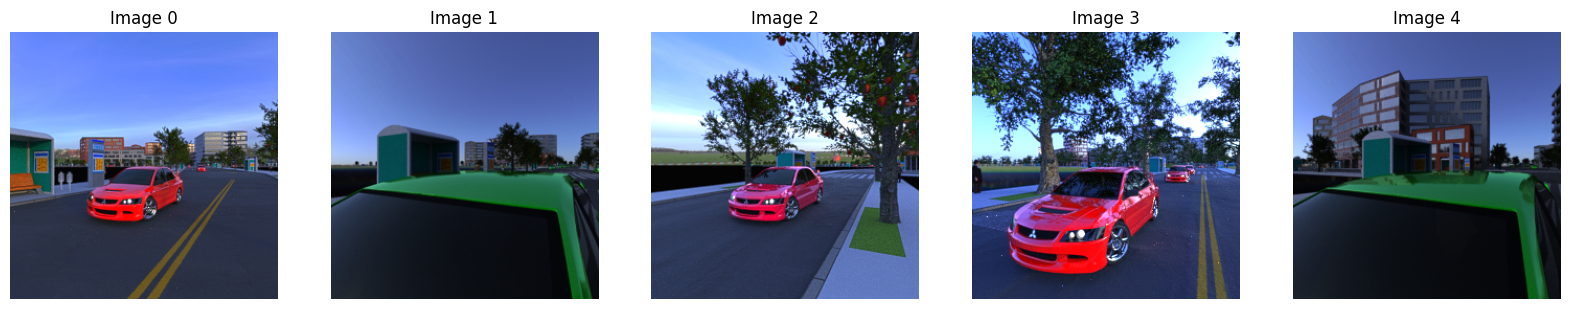

In [5]:
# Create a figure and a set of subplots with a specific size
figure, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 20))
# Loop through the first five images in the training dataset
for index in range(5):
    img, lbl = training_dataset[index]
    # Display each image in the subplot
    axes[index].imshow(img.permute(1, 2, 0))  # Adjust image dimensions for display
    axes[index].set_title(f"Image {index}")  # Set title with the current index
    axes[index].axis("off")  # Hide axes for a cleaner look


In [ ]:
# Initialize data loaders for training and testing sets
train_data_loader = DataLoader(training_dataset, batch_size=32, shuffle=True)
test_data_loader = DataLoader(testing_dataset, batch_size=32, shuffle=False)
# Set the computing device based on CUDA availability
compute_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(compute_device)

# Specify the loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

# Lists to keep track of losses and accuracies
training_losses = []
testing_losses = []
training_accuracies = []
testing_accuracies = []

# Training the model over 5 epochs and recording performance metrics
for epoch in range(5):
    epoch_train_loss = 0
    epoch_test_loss = 0
    epoch_train_accuracy = 0
    epoch_test_accuracy = 0

    # Training phase
    model.train()
    for batch_images, batch_labels in tqdm(train_data_loader):
        batch_images = batch_images.to(compute_device)
        batch_labels = batch_labels.to(compute_device)
        optimizer.zero_grad()
        predictions = model(batch_images)
        loss = loss_function(predictions, batch_labels)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
        epoch_train_accuracy += (predictions.argmax(dim=1) == batch_labels).float().sum().item()

    epoch_train_loss /= len(train_data_loader)
    epoch_train_accuracy /= len(training_dataset)
    training_losses.append(epoch_train_loss)
    training_accuracies.append(epoch_train_accuracy)

    # Evaluation phase
    model.eval()
    with torch.no_grad():
        for batch_images, batch_labels in test_data_loader:
            batch_images = batch_images.to(compute_device)
            batch_labels = batch_labels.to(compute_device)
            predictions = model(batch_images)
            loss = loss_function(predictions, batch_labels)
            epoch_test_loss += loss.item()
            epoch_test_accuracy += (predictions.argmax(dim=1) == batch_labels).float().sum().item()

    epoch_test_loss /= len(test_data_loader)
    epoch_test_accuracy /= len(testing_dataset)
    testing_losses.append(epoch_test_loss)
    testing_accuracies.append(epoch_test_accuracy)

    print(f"Epoch {epoch+1}/5, Training Loss: {epoch_train_loss:.4f}, Testing Loss: {epoch_test_loss:.4f}, "
          f"Training Accuracy: {epoch_train_accuracy:.4f}, Testing Accuracy: {epoch_test_accuracy:.4f}")

# Visualizing the training and testing losses
plt.figure(figsize=(10, 5))
plt.plot(training_losses, label="Training Loss")
plt.plot(testing_losses, label="Testing Loss")
plt.title("Losses Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Visualizing the training and testing accuracies
plt.figure(figsize=(10, 5))
plt.plot(training_accuracies, label="Training Accuracy")
plt.plot(testing_accuracies, label="Testing Accuracy")
plt.title("Accuracies Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

  6%|▋         | 1/16 [00:13<03:25, 13.73s/it]